## SAC: discrete action, full network

soft actor-critic

最大化动作的熵,增强模型的稳定性

$$
Q(s, a) + α \text{Entropy}[Q(s, *)]
$$

训练时$α$递减，为了缓解自举，用两个Value模型评估Q函数，取小

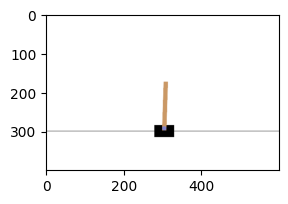

In [27]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
      over = True

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [28]:
import torch
	
# 演员模型：计算动作概率
model_action = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
	torch.nn.Softmax(dim=1),
)
model_action(torch.randn(2, 4))

tensor([[0.4807, 0.5193],
        [0.5018, 0.4982]], grad_fn=<SoftmaxBackward0>)

In [29]:
model_value1 = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
)

model_value2 = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
)

model_value1_next = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
)

model_value2_next = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
)

model_value1_next.load_state_dict(model_value1.state_dict())
model_value2_next.load_state_dict(model_value2.state_dict())
model_value1(torch.randn(2, 4))

tensor([[ 0.0560, -0.2115],
        [ 0.2084, -0.1923]], grad_fn=<AddmmBackward0>)

In [30]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    # 根据环境采样
    prob = model_action(torch.FloatTensor(state).reshape(1, 4))[0].tolist()
    action = random.choices(range(2), weights=prob, k=1)[0]

    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))
    reward_sum += reward
    
    state = next_state

  if show:
    display.clear_output(wait=True)
    env.show()

  return data, reward_sum

play()[-1]

55.0

In [31]:
class Pool:
  
  def __init__(self):
    self.pool = []
    
  def __len__(self):
    return len(self.pool)
  
  def __getitem__(self, i):
    return self.pool[i]
  
  # 更新动作
  def update(self):
    # 每次更新至少N条数据
    old_len = len(self.pool)
    while len(pool) - old_len < 200:
      self.pool.extend(play()[0])
      
    # 保留最新N条数据
    self.pool = self.pool[-2_0000:]
    
  def sample(self):
    data = random.sample(self.pool, 64)
    
    state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
    action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
    reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
    next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
    over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)
    
    return state, action, reward, next_state, over
  
pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()
len(pool), pool[0]

(215,
 (array([0.03380613, 0.02279329, 0.00323858, 0.03845455], dtype=float32),
  1,
  1.0,
  array([ 0.034262  ,  0.21786866,  0.00400767, -0.25320482], dtype=float32),
  False))

In [32]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=2e-4)
optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=2e-3)
optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=2e-3)

def soft_update(_from, _to):
  for _from, _to in zip(_from.parameters(), _to.parameters()):
    value = _to.data * 0.995 + _from.data * 0.005
    _to.data.copy_(value)
    
def get_prob_entroy(state):
  prob = model_action(torch.FloatTensor(state).reshape(-1, 4))
  entropy = prob * (prob + 1e-8).log()
  entropy = -entropy.sum(dim=1, keepdim=True)
  
  return prob, entropy
    
def requires_grad(model, value):
  for param in model.parameters():
    param.requires_grad_(value)
    
alpha = 1.0

In [33]:
# critic 模型训练
def train_value(state, action, reward, next_state, over):
  requires_grad(model_value1, True)
  requires_grad(model_value2, True)
  requires_grad(model_action, False)
  
  # 计算targets
  with torch.no_grad():
    # 计算动作熵
    prob, entropy = get_prob_entroy(next_state)
    target1 = model_value1_next(next_state)
    target2 = model_value1_next(next_state)
    target = torch.min(target1, target2)
    
  # 加权熵，越大越好
  target = (prob * target).sum(dim=1, keepdim=True)
  target = target + alpha * entropy
  target = target * 0.98 * (1 - over) + reward
  
  # 计算value
  value = model_value1(state).gather(dim=1, index=action)
  loss = torch.nn.functional.mse_loss(value, target)
  loss.backward()
  optimizer_value1.step()
  optimizer_value1.zero_grad()
  
  value = model_value2(state).gather(dim=1, index=action)
  loss = torch.nn.functional.mse_loss(value, target)
  loss.backward()
  optimizer_value2.step()
  optimizer_value2.zero_grad()
  
  return loss.item()

train_value(state, action, reward, next_state, over)

2.2396435737609863

In [34]:
# 训练actor
def train_action(state):
  requires_grad(model_action, True)
  requires_grad(model_value1, False)
  requires_grad(model_value2, False)
  
  # 计算熵
  prob, entropy = get_prob_entroy(state)
  
  # 计算value
  value1 = model_value1(state)
  value2 = model_value2(state)
  value = torch.min(value1, value2)
  
  # 求期望和
  value = (prob * value).sum(dim=1, keepdim=True)
  
  # 加权熵
  loss = -(value + alpha * entropy).mean()
  
  loss.backward()
  optimizer_action.step()
  optimizer_action.zero_grad()
  
  return loss.item()

train_action(state)

-0.6945646405220032

In [35]:
#训练
def train():
  global alpha
  model_action.train()
  model_value1.train()
  model_value2.train()

	# 共更新N轮数据
  for epoch in range(200):
    # 更新N条数据
    pool.update()
    
    # 每次更新过数据后,学习N次
    for i in range(200):
      # 采样一批
      state, action, reward, next_state, over = pool.sample()

      # 训练
      train_value(state, action, reward, next_state, over)
      train_action(state)
      soft_update(model_value1, model_value1_next)
      soft_update(model_value2, model_value2_next)

    alpha *= 0.9

    if epoch % 10 == 0:
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      print(epoch, len(pool), alpha, test_result)

train()

0 416 0.9 22.85
10 2764 0.31381059609000017 183.6
20 5145 0.10941898913151243 191.55
30 7504 0.03815204244769462 195.0
40 10404 0.013302794647291147 178.55
50 13785 0.004638397686588107 169.55
60 16959 0.0016173092699229901 161.8
70 19666 0.0005639208733960181 190.55
80 20000 0.00019662705047555326 181.1
90 20000 6.85596132412799e-05 199.75
100 20000 2.390525899882879e-05 200.0
110 20000 8.335248417898115e-06 200.0
120 20000 2.9063214161987086e-06 190.95
130 20000 1.0133716178293888e-06 198.05
140 20000 3.5334083494636473e-07 155.1
150 20000 1.2320233115273002e-07 200.0
160 20000 4.295799664301754e-08 105.4
170 20000 1.4978527259308396e-08 200.0
180 20000 5.222689519770981e-09 200.0
190 20000 1.821039234880364e-09 200.0


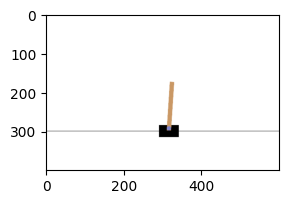

200.0

In [38]:
play(True)[-1]